In [1]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
)
import os
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import math

%load_ext lab_black

In [2]:
samples = [
    x.split("/")[-1].split("__")[0]
    for x in sorted(glob.glob("cistopic_objects_subsampled/*singlets*model*topics.pkl"))
]
if len(samples) > len(set(samples)):
    print("samples are not unique!")
else:
    print("samples are unique.")

samples are unique.


In [3]:
prediction_path_dict = {
    x.split("/")[-1].split(f"__")[0]: x
    for x in sorted(glob.glob("cell_type_classification/*__cell_type_seurat.txt"))
}
prediction_path_dict

{'master_sub_1.FIXEDCELLS': 'cell_type_classification/master_sub_1.FIXEDCELLS__cell_type_seurat.txt'}

In [4]:
cto_model_path_dict = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("cistopic_objects/*singlets*topics.pkl"))
}
cto_model_path_dict

{'master_sub_1.FIXEDCELLS': 'cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.pkl'}

master_sub_1.FIXEDCELLS
	cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.pkl exists, skipping


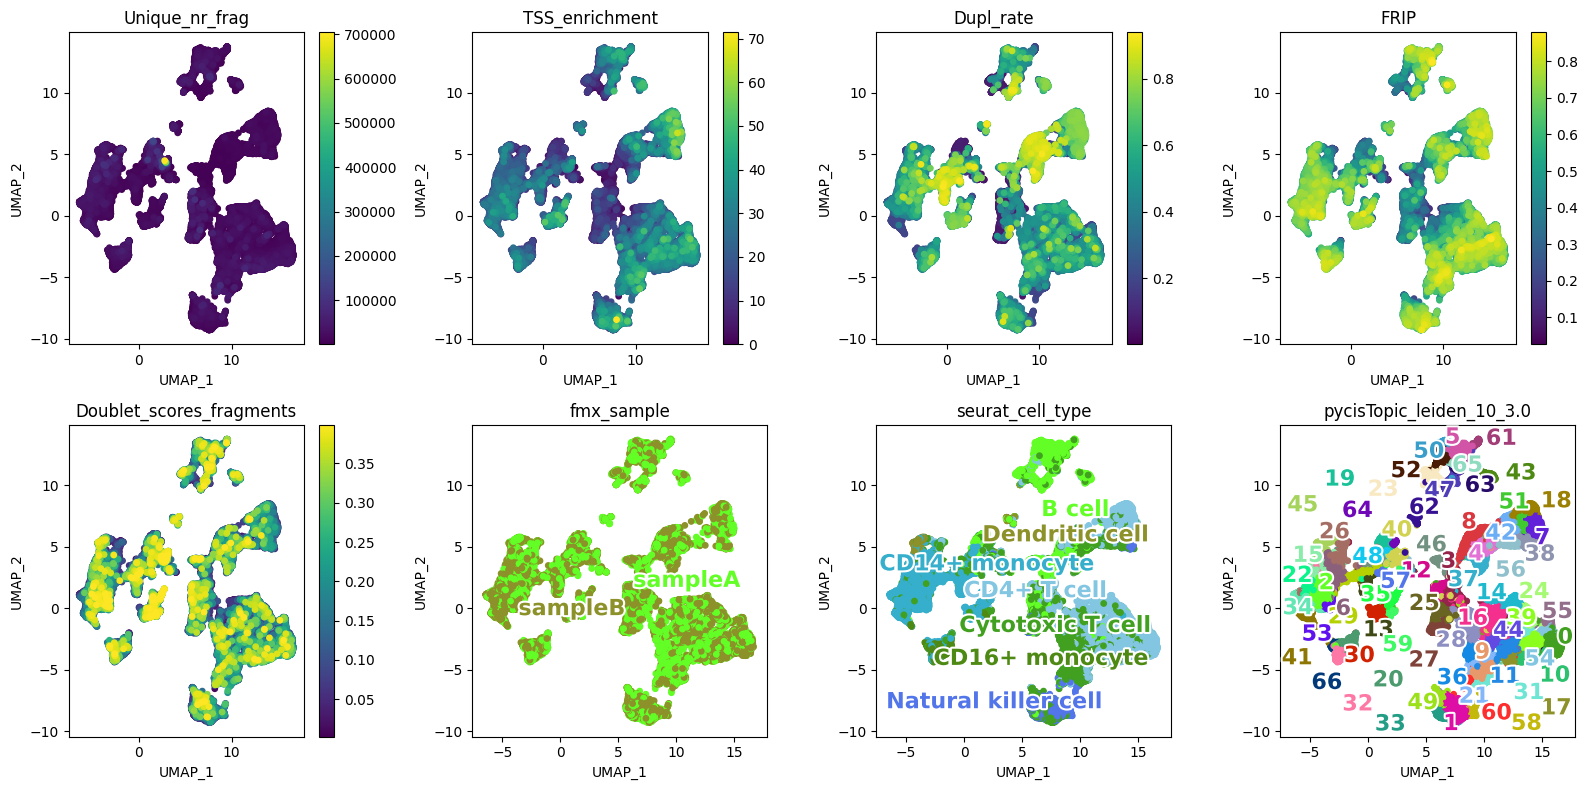

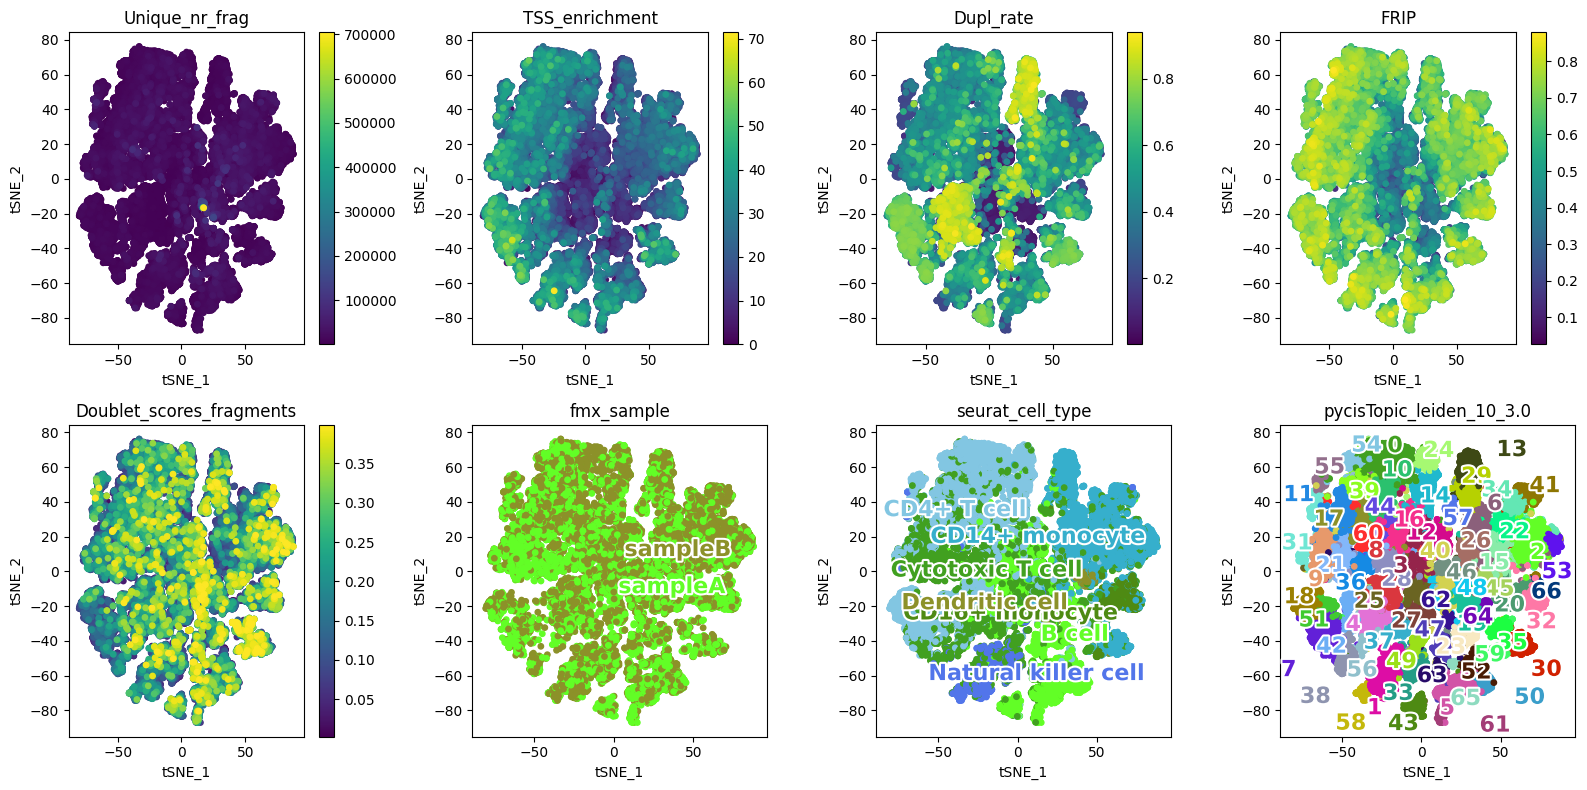

In [5]:
leiden_res = [3.0]
to_plot_leiden = ["pycisTopic_leiden_10_" + str(x) for x in leiden_res]

to_plot_vars = [
    "Unique_nr_frag",
    "TSS_enrichment",
    "Dupl_rate",
    "FRIP",
    "Doublet_scores_fragments",
    "fmx_sample",
    "seurat_cell_type",
]

for sample in cto_model_path_dict.keys():
    # for sample in ['VIB_hydrop_1.FIXEDCELLS']:
    to_plot = to_plot_vars + to_plot_leiden

    print(sample)
    cto_path = cto_model_path_dict[sample]
    cto_path_new = cto_path.replace(".pkl", ".dimreduc.pkl")

    if not sample in prediction_path_dict.keys():
        print(f"\tPredictions do not exist for {sample}! Skipping")

    else:
        predictions_path = prediction_path_dict[sample]

        if not os.path.exists(cto_path_new):
            with open(cto_path, "rb") as f:
                cto = pickle.load(f)

            ct_pred = pd.read_csv(predictions_path, sep="\t")

            # format to add to cistopic object:
            ct_annot = (
                ct_pred[["composite_sample_id", "cell_type", "cell_type_pred_score"]]
                .copy()
                .set_index("composite_sample_id")
            )
            ct_annot.columns = ["seurat_cell_type", "seurat_cell_type_pred_score"]
            ct_annot.index = [x.replace("-", "___") for x in ct_annot.index]
            ct_annot.index = [".".join(x.split(".")[:-1]) for x in ct_annot.index]
            ct_annot.index = [
                x.replace("___master_sub_1", ".FIXEDCELLS") for x in ct_annot.index
            ]
            ct_annot.index = [x.replace("__", "___") for x in ct_annot.index]

            index_old = cto.cell_data.index

            if sample.split(".")[0] == "VIB_hydrop_1":
                #     ct_annot.index = [x.split('___')[0] + '___' + x.split('___')[2].split('.')[0] + x.split('___')[1] + '.' + x.split('___')[2].split('.')[-1] for x in ct_annot.index]
                #    cto.cell_data.index = [x.replace('-1','').replace('-2','') for x in cto.cell_data.index]
                ct_annot.index = [
                    x.replace(
                        "___2___VIB_hydrop_1.FIXEDCELLS", "___VIB_hydrop_12.FIXEDCELLS"
                    ).replace(
                        "___1___VIB_hydrop_1.FIXEDCELLS", "___VIB_hydrop_11.FIXEDCELLS"
                    )
                    for x in ct_annot.index
                ]
            elif sample.split(".")[0] == "VIB_hydrop_2":
                ct_annot.index = [
                    x.replace(
                        "___2___VIB_hydrop_2.FIXEDCELLS", "___VIB_hydrop_22.FIXEDCELLS"
                    ).replace(
                        "___1___VIB_hydrop_2.FIXEDCELLS", "___VIB_hydrop_21.FIXEDCELLS"
                    )
                    for x in ct_annot.index
                ]

            # cto.add_cell_data(ct_annot)
            # cto.cell_data.index = index_old

            cto.cell_data["seurat_cell_type"] = ct_annot["seurat_cell_type"]
            cto.cell_data["seurat_cell_type_pred_score"] = ct_annot[
                "seurat_cell_type_pred_score"
            ]
            cto.cell_names = cto.cell_data.index

            cto.projections["cell"] = {}
            find_clusters(
                cto, target="cell", k=10, res=leiden_res, prefix="pycisTopic_"
            )
            run_umap(cto, target="cell")
            run_tsne(cto, target="cell")

            if not "fmx_sample" in cto.cell_data.columns:
                to_plot.remove("fmx_sample")

            n_to_plot = len(to_plot)
            n_cols = 4
            n_rows = math.ceil(n_to_plot / n_cols)

            plot_metadata(
                cto,
                reduction_name="UMAP",
                variables=to_plot,
                target="cell",
                num_columns=4,
                text_size=16,
                dot_size=15,
                figsize=(n_cols * 4, n_rows * 4),
                save=f"plots_qc/{sample}__umap_summary.png",
            )

            plot_metadata(
                cto,
                reduction_name="tSNE",
                variables=to_plot,
                target="cell",
                num_columns=4,
                text_size=16,
                dot_size=15,
                figsize=(n_cols * 4, n_rows * 4),
                save=f"plots_qc/{sample}__tsne_summary.png",
            )

            with open(cto_path_new, "wb") as f:
                pickle.dump(cto, f, protocol=4)

        else:
            print(f"\t{cto_path_new} exists, skipping")

            umap_path = f"plots_qc/{sample}__umap_summary.png"
            tsne_path = f"plots_qc/{sample}__tsne_summary.png"

            if os.path.exists(umap_path):
                display(Image(umap_path))

            else:
                with open(cto_path_new, "rb") as f:
                    cto = pickle.load(f)

                if not "fmx_sample" in cto.cell_data.columns:
                    to_plot.remove("fmx_sample")

                n_to_plot = len(to_plot)
                n_cols = 4
                n_rows = math.ceil(n_to_plot / n_cols)

                plot_metadata(
                    cto,
                    reduction_name="UMAP",
                    variables=to_plot,
                    target="cell",
                    num_columns=4,
                    text_size=16,
                    dot_size=15,
                    figsize=(n_cols * 4, n_rows * 4),
                    save=f"plots_qc/{sample}__umap_summary.png",
                )

            if os.path.exists(tsne_path):
                display(Image(tsne_path))

            else:
                with open(cto_path_new, "rb") as f:
                    cto = pickle.load(f)

                n_to_plot = len(to_plot)
                n_cols = 4
                n_rows = math.ceil(n_to_plot / n_cols)

                plot_metadata(
                    cto,
                    reduction_name="tSNE",
                    variables=to_plot,
                    target="cell",
                    num_columns=4,
                    text_size=16,
                    dot_size=15,
                    figsize=(n_cols * 4, n_rows * 4),
                    save=f"plots_qc/{sample}__tsne_summary.png",
                )

# derive consensus clusters

In [34]:
cto_model_path_dict = {
    x.split("/")[-1].split("__")[0] + "." + x.split("/")[-1].split(".")[-4]: x
    for x in sorted(glob.glob("cistopic_objects/*model*dimreduc.pkl"))
}
cto_model_path_dict

{'master_sub_1.FIXEDCELLS.singlets': 'cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.pkl'}

cell_types = list(celldata['seurat_cell_type'].unique())
palette = list(sns.color_palette('husl',len(cell_types)))
palette = list(sns.color_palette('Set2'))

color_palette = {cell_type: palette[cell_types.index(cell_type)] for cell_type in cell_types}

pprint.pprint(color_palette)

In [35]:
color_palette = {
    "B cell": (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
    "CD14+ monocyte": (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
    "CD16+ monocyte": (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
    "CD4+ T cell": (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
    "Cytotoxic T cell": (0.9587050080494409, 0.3662259565791742, 0.9231469575614251),
    "Dendritic cell": (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
    "Natural killer cell": (
        0.9677975592919913,
        0.44127456009157356,
        0.5358103155058701,
    ),
}

In [36]:
palette_dict = {x: color_palette for x in ["seurat_cell_type", "consensus_cell_type"]}

cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.pkl already exists!


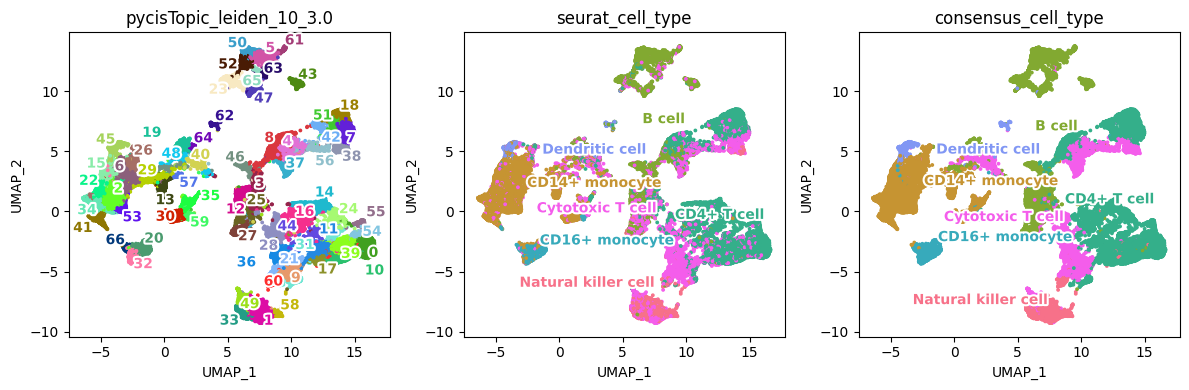

In [11]:
clustering = "pycisTopic_leiden_10_3.0"
ct_pred_thr = 0.7

to_plot = [clustering, "seurat_cell_type", "consensus_cell_type"]
n_to_plot = len(to_plot)
n_cols = 3
n_rows = math.ceil(n_to_plot / n_cols)

clust_consensus = []
write = True
# for sample in ["BRO_mtscatac_1.LIBDS"]:
for sample in cto_model_path_dict.keys():
    cto_path = cto_model_path_dict[sample]
    cto_path_new = cto_path.replace(".pkl", ".consensus.pkl")
    if not os.path.exists(cto_path_new):
        with open(cto_path, "rb") as f:
            cto = pickle.load(f)

        major_cell_type = []
        frac_of_cluster = []
        next_celltype = []
        next_frac_of_cluster = []
        diff_to_next = []

        celldata = cto.cell_data

        for c in celldata[clustering].unique():
            c1 = celldata[celldata[clustering] == c]
            # find proportions of each unique cell type detected in this cluster:
            ctp = pd.DataFrame(
                [
                    c1["seurat_cell_type"].unique(),
                    [
                        c1[c1["seurat_cell_type"] == x].shape[0] / c1.shape[0]
                        for x in c1["seurat_cell_type"].unique()
                    ],
                ]
            ).T
            # sort/rank by proportion:
            ctps = ctp.sort_values(1, ascending=False)
            if ctp.shape[0] > 1:
                n = ctps.iloc[1, 0]  # next cell type detected
                dtn = ctps.iloc[0, 1] - ctps.iloc[1, 1]  # distance to next
                dtnf = ctps.iloc[1, 1]
            else:
                dtn = None
                dtnf = None
                n = None
            major_cell_type.append(ctps.iloc[0, 0])
            frac_of_cluster.append(ctps.iloc[0, 1])
            next_celltype.append(n)
            next_frac_of_cluster.append(dtnf)
            diff_to_next.append(dtn)

        # collect results for this sample
        clust_consensus = (
            pd.DataFrame(
                [
                    celldata[clustering].unique(),
                    major_cell_type,
                    frac_of_cluster,
                    next_celltype,
                    next_frac_of_cluster,
                    diff_to_next,
                ]
            )
            .T.set_axis(
                [
                    "cluster",
                    "major_cell_type",
                    "frac_of_cluster",
                    "next_celltype",
                    "next_frac_of_cluster",
                    "diff_to_next",
                ],
                axis=1,
            )
            .set_index(sample + "__" + celldata[clustering].unique())
        )
        print(sample)
        clust_consensus["cluster_counts"] = clust_consensus["cluster"].map(
            celldata[clustering].value_counts()
        )
        # print only rows where there is another cell type within 20%:
        if sum(clust_consensus["diff_to_next"] < 0.20) > 0:
            display(clust_consensus[clust_consensus["diff_to_next"] < 0.20])

        else:
            print("No discrepant clusters")

        # add the mapping
        cto.cell_data["consensus_cell_type"] = ""
        for i, r in clust_consensus.iterrows():
            ix = cto.cell_data[clustering] == r["cluster"]
            cto.cell_data.loc[ix, "consensus_cell_type"] = r["major_cell_type"]

        plot_metadata(
            cto,
            reduction_name="UMAP",
            variables=to_plot,
            target="cell",
            num_columns=n_cols,
            text_size=10,
            dot_size=3,
            figsize=(n_cols * 4, n_rows * 4),
            save=f"plots_qc/{sample}__consensus_clusters_qc.png",
            color_dictionary=palette_dict,
        )

        if write == True:
            with open(cto_path_new, "wb") as f:
                pickle.dump(cto, f)
            print("dumped_cto")
    else:
        print(f"{cto_path_new} already exists!")
        display(Image(f"plots_qc/{sample}__consensus_clusters_qc.png"))

# check integration/LISI

In [12]:
with open(
    "cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.pkl",
    "rb",
) as f:
    cto = pickle.load(f)

In [13]:
cto.cell_data

cisTopic_log_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...             2.444045   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...             3.535041   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...             3.768564   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...             3.816109   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...             2.826075   
...                                                                 ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                      3.706974   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                      3.909984   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                      3.918083   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                      3.881271   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                       3.57565   

                                                   cisTopic_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...              278   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...             3428   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...             5869   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...             6548   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...              670   
...                                                             ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                      5093   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                      8128   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                      8281   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                      7608   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                      3764   

                                                   cisTopic_log_nr_acc  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...            2.434569   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...            3.479287   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...            3.707826   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...            3.737352   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...            2.155336   
...                                                                ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                     3.652053   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                     3.848928   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                     3.851258   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                     3.811106   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                     3.542078   

                                                   cisTopic_nr_acc  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...             272   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...            3015   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...            5103   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...            5462   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...             143   
...                                                            ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                     4488   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                     7062   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                     7100   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                     6473   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                     3484   

                                                    Log_total_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...           3.562887   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...           4.291191   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...           4.322261   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...           4.247384   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...           3.416807   
...                                                               ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS               

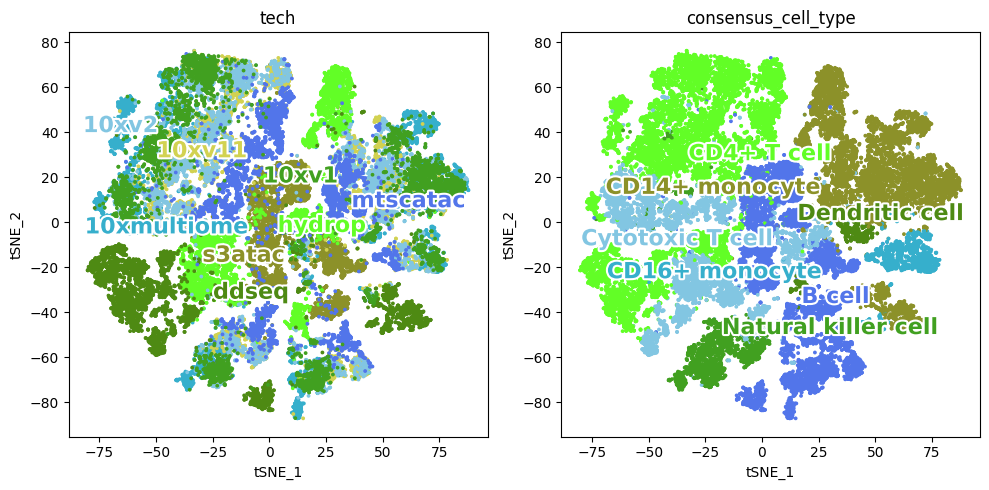

In [14]:
plot_metadata(
    cto,
    reduction_name="tSNE",
    num_columns=2,
    variables=["tech", "consensus_cell_type"],
    target="cell",
    text_size=16,
    dot_size=3,
    figsize=(10, 5)
    # save=f"plots_qc/{sample}__tsne_summary.png",
)

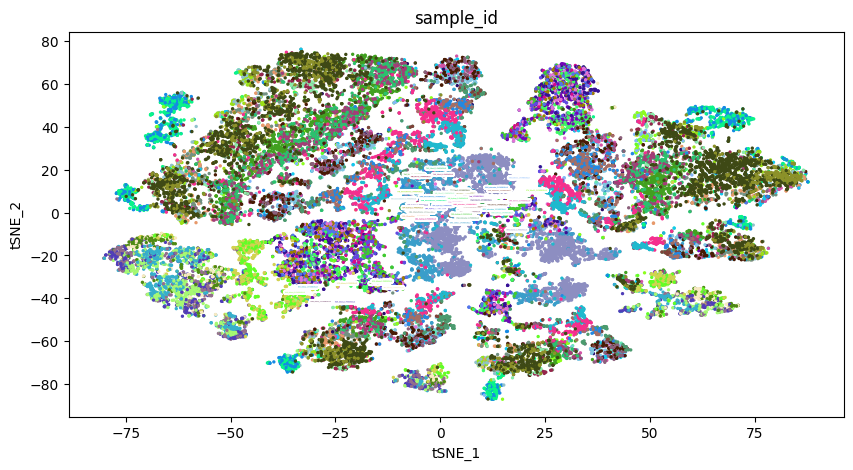

In [15]:
plot_metadata(
    cto,
    reduction_name="tSNE",
    num_columns=1,
    variables=["sample_id"],
    target="cell",
    text_size=0,
    dot_size=2,
    figsize=(10, 5)
    # save=f"plots_qc/{sample}__tsne_summary.png",
)

In [ ]:
plot_metadata(
    cto,
    reduction_name="harmony_tSNE",
    num_columns=2,
    variables=["tech", "consensus_cell_type"],
    target="cell",
    text_size=16,
    dot_size=3,
    figsize=(10, 5)
    # save=f"plots_qc/{sample}__tsne_summary.png",
)

In [ ]:
plot_metadata(
    cto,
    reduction_name="harmony_tSNE",
    num_columns=1,
    variables=["sample_id"],
    target="cell",
    text_size=0,
    dot_size=2,
    figsize=(10, 5)
    # save=f"plots_qc/{sample}__tsne_summary.png",
)

# check consensus cell type on harmony

In [6]:
with open(
    "cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.pkl",
    "rb",
) as f:
    cto = pickle.load(f)

In [9]:
df = pd.read_csv("harmony_clusters.tsv", sep="\t", index_col=0)

In [11]:
cto.cell_data["pycisTopic_harmonyleiden_10_3.0"] = df["pycisTopic_harmonyleiden_10_3.0"]

In [12]:
write = False

master_sub_1.FIXEDCELLS


cluster      major_cell_type frac_of_cluster     next_celltype  \
0       38          CD4+ T cell        0.375648  Cytotoxic T cell   
1       39       CD14+ monocyte        0.416667       CD4+ T cell   
5       15               B cell        0.401136  Cytotoxic T cell   
7       43               B cell        0.410029  Cytotoxic T cell   
8       48  Natural killer cell        0.419476  Cytotoxic T cell   
15      47  Natural killer cell        0.483636            B cell   
38      22     Cytotoxic T cell           0.375    CD14+ monocyte   
39      23               B cell        0.424471  Cytotoxic T cell   
42       9  Natural killer cell        0.451751  Cytotoxic T cell   
47      33     Cytotoxic T cell        0.401623       CD4+ T cell   

   next_frac_of_cluster diff_to_next  cluster_counts  
0              0.354922     0.020725             386  
1              0.257812     0.158854             384  
5              0.309091     0.092045             880  
7              0.241888     0.168142             339  
8              0.322097     0.097378             267  
15             0.287273     0.196364             275  
38             0.372093     0.002907             688  
39             0.253776     0.170695             662  
42             0.448335     0.003416            1171  
47             0.375254     0.026369             493

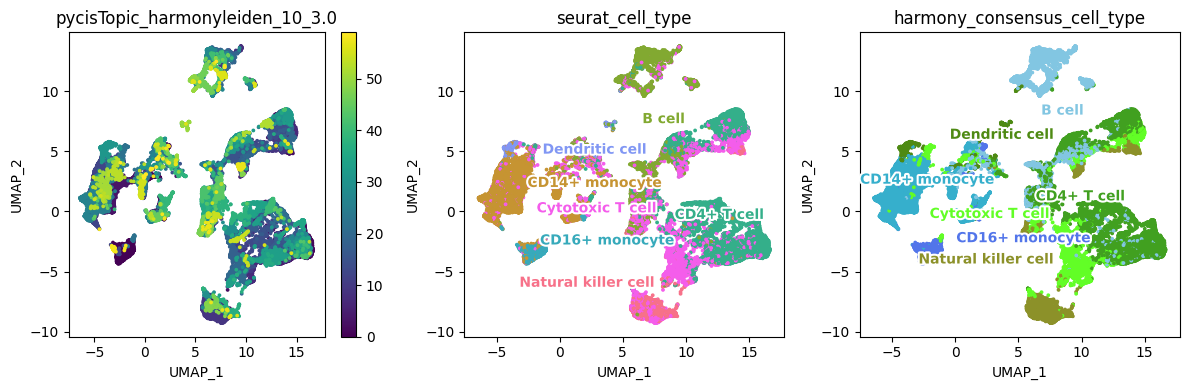

dumped_cto


In [38]:
clustering = "pycisTopic_harmonyleiden_10_3.0"
ct_pred_thr = 0.7

to_plot = [clustering, "seurat_cell_type", "harmony_consensus_cell_type"]
n_to_plot = len(to_plot)
n_cols = 3
n_rows = math.ceil(n_to_plot / n_cols)

clust_consensus = []
write = True
# for sample in ["BRO_mtscatac_1.LIBDS"]:


major_cell_type = []
frac_of_cluster = []
next_celltype = []
next_frac_of_cluster = []
diff_to_next = []

celldata = cto.cell_data

for c in celldata[clustering].unique():
    c1 = celldata[celldata[clustering] == c]
    # find proportions of each unique cell type detected in this cluster:
    ctp = pd.DataFrame(
        [
            c1["seurat_cell_type"].unique(),
            [
                c1[c1["seurat_cell_type"] == x].shape[0] / c1.shape[0]
                for x in c1["seurat_cell_type"].unique()
            ],
        ]
    ).T
    # sort/rank by proportion:
    ctps = ctp.sort_values(1, ascending=False)
    if ctp.shape[0] > 1:
        n = ctps.iloc[1, 0]  # next cell type detected
        dtn = ctps.iloc[0, 1] - ctps.iloc[1, 1]  # distance to next
        dtnf = ctps.iloc[1, 1]
    else:
        dtn = None
        dtnf = None
        n = None
    major_cell_type.append(ctps.iloc[0, 0])
    frac_of_cluster.append(ctps.iloc[0, 1])
    next_celltype.append(n)
    next_frac_of_cluster.append(dtnf)
    diff_to_next.append(dtn)

# collect results for this sample
clust_consensus = pd.DataFrame(
    [
        celldata[clustering].unique(),
        major_cell_type,
        frac_of_cluster,
        next_celltype,
        next_frac_of_cluster,
        diff_to_next,
    ]
).T.set_axis(
    [
        "cluster",
        "major_cell_type",
        "frac_of_cluster",
        "next_celltype",
        "next_frac_of_cluster",
        "diff_to_next",
    ],
    axis=1,
)
print(sample)
clust_consensus["cluster_counts"] = clust_consensus["cluster"].map(
    celldata[clustering].value_counts()
)
# print only rows where there is another cell type within 20%:
if sum(clust_consensus["diff_to_next"] < 0.20) > 0:
    display(clust_consensus[clust_consensus["diff_to_next"] < 0.20])

else:
    print("No discrepant clusters")

# add the mapping
cto.cell_data["harmony_consensus_cell_type"] = ""
for i, r in clust_consensus.iterrows():
    ix = cto.cell_data[clustering] == r["cluster"]
    cto.cell_data.loc[ix, "harmony_consensus_cell_type"] = r["major_cell_type"]

plot_metadata(
    cto,
    reduction_name="UMAP",
    variables=to_plot,
    target="cell",
    num_columns=n_cols,
    text_size=10,
    dot_size=3,
    figsize=(n_cols * 4, n_rows * 4),
    save=f"plots_qc/{sample}__harmony_consensus_clusters_qc.png",
    color_dictionary=palette_dict,
)

if write == True:
    with open(
        "master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus_harmony.pkl",
        "wb",
    ) as f:
        pickle.dump(cto, f)
    print("dumped_cto")

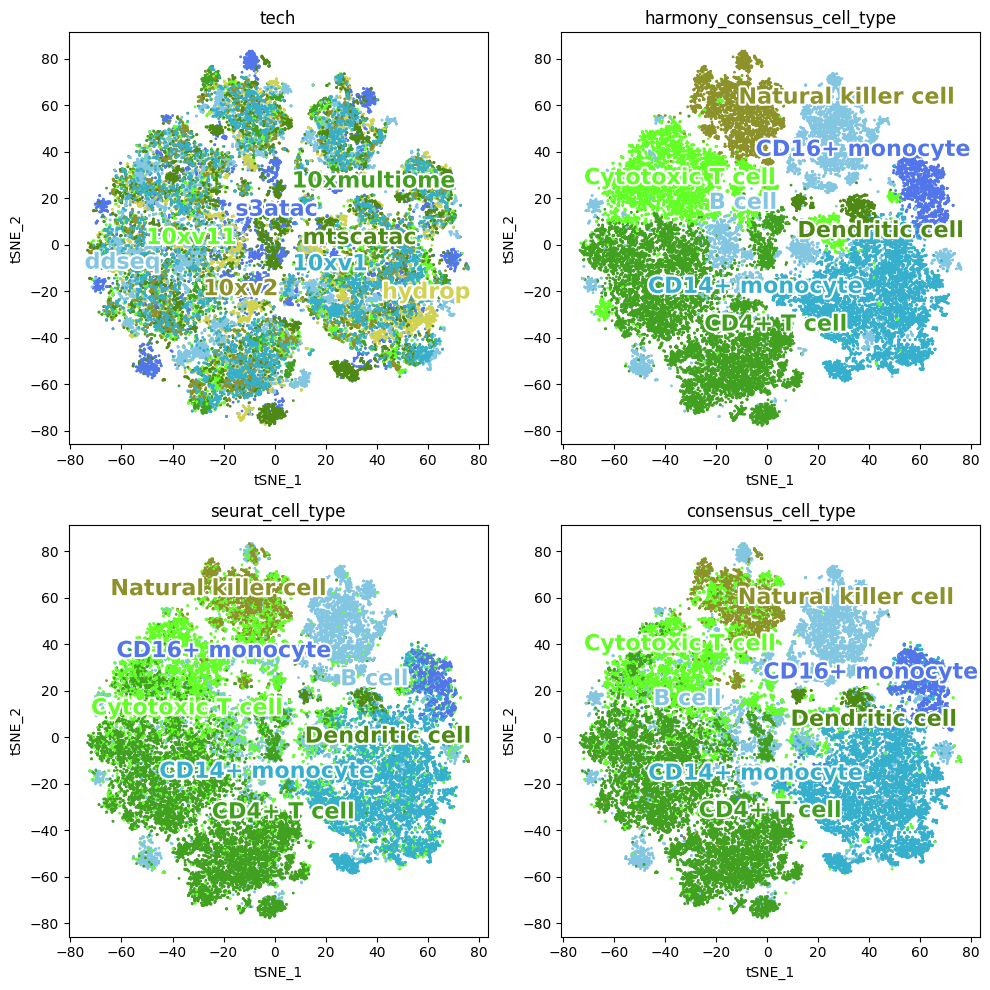

In [41]:
plot_metadata(
    cto,
    reduction_name="harmony_tSNE",
    num_columns=2,
    variables=[
        "tech",
        "harmony_consensus_cell_type",
        "seurat_cell_type",
        "consensus_cell_type",
    ],
    target="cell",
    text_size=16,
    dot_size=1,
    figsize=(10, 10)
    # save=f"plots_qc/{sample}__tsne_summary.png",
)

In [48]:
cto.cell_data.groupby("tech")["harmony_consensus_cell_type"].value_counts()

tech         harmony_consensus_cell_type
10xmultiome  CD4+ T cell                    1295
             CD14+ monocyte                 1108
             Cytotoxic T cell                748
             B cell                          621
             Natural killer cell             603
             CD16+ monocyte                  329
             Dendritic cell                  127
10xv1        CD4+ T cell                    1444
             CD14+ monocyte                 1433
             Cytotoxic T cell                620
             B cell                          539
             Natural killer cell             446
             CD16+ monocyte                  242
             Dendritic cell                  107
10xv11       CD4+ T cell                    1627
             CD14+ monocyte                 1178
             Cytotoxic T cell                727
             B cell                          477
             Natural killer cell             477
             CD16+ monocyte 

In [49]:
cto.cell_data.groupby("tech")["seurat_cell_type"].value_counts()

tech         seurat_cell_type   
10xmultiome  Cytotoxic T cell       1304
             CD4+ T cell            1246
             CD14+ monocyte         1027
             B cell                  502
             Natural killer cell     433
             CD16+ monocyte          244
             Dendritic cell           75
10xv1        CD4+ T cell            1517
             CD14+ monocyte         1405
             Cytotoxic T cell        852
             B cell                  455
             Natural killer cell     349
             CD16+ monocyte          181
             Dendritic cell           72
10xv11       CD4+ T cell            1557
             CD14+ monocyte         1153
             Cytotoxic T cell       1000
             Natural killer cell     449
             B cell                  409
             CD16+ monocyte          175
             Dendritic cell           88
10xv2        CD4+ T cell            1925
             CD14+ monocyte         1076
             Cytotoxic T

# calculate LISI

In [25]:
from harmonypy.lisi import compute_lisi
import seaborn as sns
import math

In [29]:
cto.cell_data["UMAP_1"] = cto.projections["cell"]["UMAP"]["UMAP_1"]
cto.cell_data["UMAP_2"] = cto.projections["cell"]["UMAP"]["UMAP_2"]

cto.cell_data["tSNE_1"] = cto.projections["cell"]["tSNE"]["tSNE_1"]
cto.cell_data["tSNE_2"] = cto.projections["cell"]["tSNE"]["tSNE_2"]

cto.cell_data["harmony_UMAP_1"] = cto.projections["cell"]["harmony_UMAP"]["UMAP_1"]
cto.cell_data["harmony_UMAP_2"] = cto.projections["cell"]["harmony_UMAP"]["UMAP_2"]

cto.cell_data["harmony_tSNE_1"] = cto.projections["cell"]["harmony_tSNE"]["tSNE_1"]
cto.cell_data["harmony_tSNE_2"] = cto.projections["cell"]["harmony_tSNE"]["tSNE_2"]

In [35]:
cto.cell_data["center"] = [x.split("_")[0] for x in cto.cell_data["sample_id"]]

In [37]:
cto.cell_data["tech_center"] = cto.cell_data["tech"] + "_" + cto.cell_data["center"]

In [39]:
dimreduc_list = ["tSNE", "UMAP", "harmony_tSNE", "harmony_UMAP"]
var_list = ["sample_id", "tech", "center", "tech_center", "consensus_cell_type"]

for dimreduc in dimreduc_list:
    for var in var_list:
        if not f"{dimreduc}_LISI_by_{var}" in cto.cell_data.columns:
            lisi = compute_lisi(
                cto.projections["cell"][dimreduc].to_numpy(),
                metadata=cto.cell_data,
                label_colnames=[var],
            )
            cto.cell_data[f"{dimreduc}_LISI_by_{var}"] = lisi
        else:
            print(f"{dimreduc}_LISI_by_{var} already in columns")

tSNE_LISI_by_sample_id already in columns
tSNE_LISI_by_tech already in columns
tSNE_LISI_by_center already in columns
tSNE_LISI_by_tech_center already in columns
tSNE_LISI_by_consensus_cell_type already in columns
UMAP_LISI_by_sample_id already in columns
UMAP_LISI_by_tech already in columns
UMAP_LISI_by_center already in columns
UMAP_LISI_by_tech_center already in columns
UMAP_LISI_by_consensus_cell_type already in columns
harmony_tSNE_LISI_by_sample_id already in columns
harmony_tSNE_LISI_by_tech already in columns
harmony_tSNE_LISI_by_center already in columns
harmony_tSNE_LISI_by_tech_center already in columns
harmony_tSNE_LISI_by_consensus_cell_type already in columns
harmony_UMAP_LISI_by_sample_id already in columns
harmony_UMAP_LISI_by_tech already in columns
harmony_UMAP_LISI_by_center already in columns
harmony_UMAP_LISI_by_tech_center already in columns
harmony_UMAP_LISI_by_consensus_cell_type already in columns


In [44]:
cto.cell_data.to_csv(
    "cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.cell_data.csv",
    index=True,
    header=True,
)

In [42]:
with open(
    "cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.pkl",
    "wb",
) as f:
    pickle.dump(cto, f, protocol=4)

In [48]:
df = pd.read_csv(
    "cistopic_objects/master_sub_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_20topics.dimreduc.consensus.cell_data.tsv",
    sep="\t",
    index_col=0,
    header=0,
)

In [71]:
df

cisTopic_log_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...              2.444045   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...              3.535041   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...              3.768564   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...              3.816109   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...              2.826075   
...                                                                  ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                       3.706974   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                       3.909984   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                       3.918083   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                       3.881271   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                       3.575650   

                                                    cisTopic_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...               278   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...              3428   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...              5869   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...              6548   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...               670   
...                                                              ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                       5093   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                       8128   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                       8281   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                       7608   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                       3764   

                                                    cisTopic_log_nr_acc  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...             2.434569   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...             3.479287   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...             3.707826   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...             3.737352   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...             2.155336   
...                                                                 ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                      3.652053   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                      3.848928   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                      3.851258   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                      3.811106   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                      3.542078   

                                                    cisTopic_nr_acc  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...              272   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...             3015   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...             5103   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...             5462   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...              143   
...                                                             ...   
TCACAGAGTGCCCGAT___VIB_10xv1_1.FIXEDCELLS                      4488   
CAGTGCGAGAATCAAC___VIB_10xv1_2.FIXEDCELLS                      7062   
AATGCCAGTTTCGTTT___VIB_10xv1_2.FIXEDCELLS                      7100   
TCTAGTTCAATGATGA___VIB_10xv1_1.FIXEDCELLS                      6473   
CAATCCCCATACTGCA___VIB_10xv1_2.FIXEDCELLS                      3484   

                                                    Log_total_nr_frag  \
GGTTAGTTGGCTGCATTACGTACTCATA___OHS_s3atac_1.FIX...           3.562887   
GGTTAGTTGCCAAGGCAAGCTCATTG___OHS_s3atac_2.FIXED...           4.291191   
GAAGAGTATTTTGGTTCTCAGCTTGTCA___OHS_s3atac_1.FIX...           4.322261   
GAAGAGTATTTGGCTCATATGTGTCGGA___OHS_s3atac_1.FIX...           4.247384   
ATTGAGGATATATTGCAGCTCGCCGATC___OHS_s3atac_1.FIX...           3.416807   
...                                                               ...   
TCACAGAGT

### Combined plot

In [134]:
tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}


tech_alias_order = [
    "10x v1",
    "10x v1.1",
    "10x v2",
    "10x Multiome",
    "mtscATAC-seq",
    "ddSEQ SureCell",
    "s3-ATAC",
    "HyDrop",
]

tech_alias_color_palette = {
    tech_alias_dict[x]: tech_color_palette[x] for x in tech_color_palette.keys()
}

In [120]:
df_sub1 = pd.DataFrame()
df_sub1["LISI"] = df["tSNE_LISI_by_tech"]
df_sub1["harmony"] = "pre-Harmony"

df_sub2 = pd.DataFrame()
df_sub2["LISI"] = df["harmony_tSNE_LISI_by_tech"]
df_sub2["harmony"] = "post-Harmony"

df_merged = pd.concat([df_sub1, df_sub2])

In [121]:
df_merged["Technology"] = [
    tech_alias_dict[x.split("___")[1].split("_")[1]] for x in df_merged.index
]
df_merged.reset_index(inplace=True, drop=True)

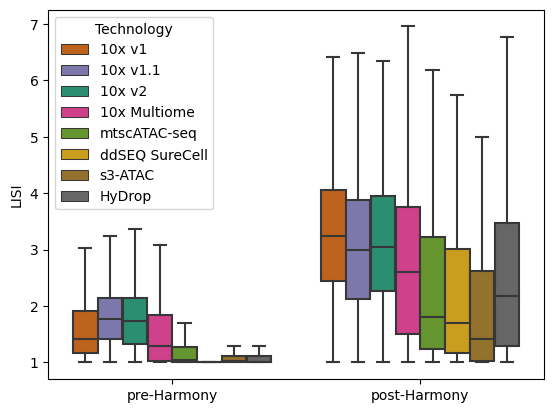

In [137]:
sns.boxplot(
    df_merged,
    y="LISI",
    x="harmony",
    hue="Technology",
    showfliers=False,
    hue_order=tech_alias_order,
    palette=tech_alias_color_palette,
)
plt.xticks(rotation=0, ha="center")
plt.xlabel(None)
plt.savefig("plts_final/LISI_bytech_pre_post_harmony.png", dpi=600, facecolor="white")
plt.savefig("plts_final/LISI_bytech_pre_post_harmony.svg", dpi=600, facecolor="white")

In [68]:
df.columns

Index(['cisTopic_log_nr_frag', 'cisTopic_nr_frag', 'cisTopic_log_nr_acc',
       'cisTopic_nr_acc', 'Log_total_nr_frag', 'Log_unique_nr_frag',
       'Total_nr_frag', 'Unique_nr_frag', 'Dupl_nr_frag', 'Dupl_rate',
       'Total_nr_frag_in_regions', 'Unique_nr_frag_in_regions', 'FRIP',
       'TSS_enrichment', 'sample_id', 'barcode', 'Doublet_scores_fragments',
       'Predicted_doublets_fragments', 'fmx_droplet_type', 'fmx_sample',
       'tech', 'seurat_cell_type', 'seurat_cell_type_pred_score',
       'pycisTopic_leiden_10_3.0', 'consensus_cell_type', 'UMAP_1', 'UMAP_2',
       'tSNE_1', 'tSNE_2', 'harmony_UMAP_1', 'harmony_UMAP_2',
       'harmony_tSNE_1', 'harmony_tSNE_2', 'tSNE_LISI_by_sample_id',
       'tSNE_LISI_by_tech', 'center', 'tSNE_LISI_by_center', 'tech_center',
       'tSNE_LISI_by_tech_center', 'tSNE_LISI_by_consensus_cell_type',
       'UMAP_LISI_by_sample_id', 'UMAP_LISI_by_tech', 'UMAP_LISI_by_center',
       'UMAP_LISI_by_tech_center', 'UMAP_LISI_by_consensus_cell_

<AxesSubplot: xlabel='harmony_tSNE_1', ylabel='harmony_tSNE_2'>

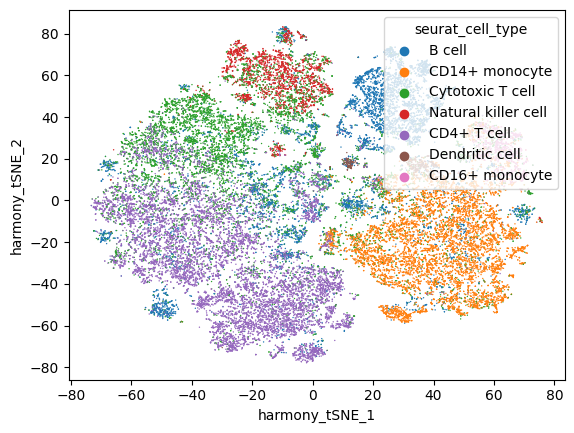

In [69]:
sns.scatterplot(
    df,
    x="harmony_tSNE_1",
    y="harmony_tSNE_2",
    s=1,
    linewidth=0,
    hue="seurat_cell_type",
)

<AxesSubplot: xlabel='harmony_tSNE_1', ylabel='harmony_tSNE_2'>

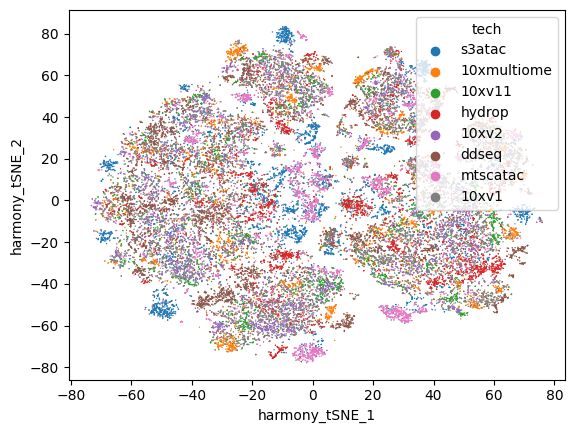

In [55]:
sns.scatterplot(
    df, x="harmony_tSNE_1", y="harmony_tSNE_2", s=1, linewidth=0, hue="tech"
)